# Model Experimentation 5: Pretrain backbone

In this next iteration, we will attempt to pretrain the backbone on a classification task to prepare it for object detection later on.

I also propose a new lightweight architecture that aggressively reduces the kernel size which consists of the following layers:

| Type          | Filters | Size/Stride |
|---------------|---------|-------------|
| Convolutional | 64      | 3x3/1       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 128     | 3x3/1       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 256     | 3x3/2       |
| Convolutional | 128     | 1x1/1       |
| Convolutional | 256     | 3x3/2       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 512     | 3x3/3       |
| Convolutional | 256     | 1x1/1       |
| Convolutional | 512     | 3x3/3       |
|---------------|---------|-------------|
| Convolutional | 500     | 1x1/1       |
| AvgPool       |         | Global      |

The output has shape: `[1, 500]`

In [1]:
import IPython.core.display as di
from IPython.display import Markdown as md

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )
    
def md_cat(file_path):
    with open(file_path) as file:
        return md(f"```python\n{file.read()}\n```")

toggle_code()

Toggle code

In [2]:
import json
import os
import sys
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
from cached_property import cached_property
from matplotlib import patches
from PIL import Image
from tqdm.notebook import tqdm, trange

In [3]:
data_path = "../data"
sys.path.append(data_path)

In [4]:
from Dataset import Dataset, TestDataset, originals, boxes
from LossAccumulator import LossAccumulator
from Parameters import Parameters
from PolyLearningRateDecay import PolyLearningRateDecay

## Parameters

In [5]:
params = Parameters("params.yml")

In [6]:
assert params.use_gpu

In [7]:
log = params.get_logger('Model_v5_pretrain')

In [8]:
if not os.path.isdir(params.save_model_path):
    os.mkdir(params.save_model_path)

## Load Data

See the [data augmentation notebook](https://github.com/antoniojkim/WheresWaldo-YoloV3/blob/master/data/data.ipynb) for more details on how the data was curated and augmented.

In [9]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_inverse(y):
    return np.log(y/(1-y))

In [10]:
class DatasetV5_pretrain(Dataset):
    
    classes = {name: i for i, name in enumerate(boxes)}
    
    def get_label(self, index, image):
        has_waldo = int("box" in self.data[index])
        waldo_map = self.classes[self.data[index]["name"]]
        return has_waldo, waldo_map
    
np.random.seed(20200507)
dataset = DatasetV5_pretrain(ntimes=100)
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

In [12]:
class TestDataset_pretrain(TestDataset):
    def __init__(self):
        super().__init__()
        self.data = [(originals[key], key) for key in originals.keys()]
        
    def get_label(self, index, image):
        has_waldo = 1
        waldo_map = DatasetV5_pretrain.classes[self.data[index][1]]
        return has_waldo, waldo_map


test_dataloader = torch.utils.data.DataLoader(
    TestDataset_pretrain(),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = False,
    drop_last   = True
)

## Model Definition

In [14]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [15]:
# resnet = torchv.models.resnet50(pretrained=True)
# resnet = to_device(resnet)

# for param in resnet.parameters():
#     param.requires_grad = False

In [16]:
class WaldoNet(torch.nn.Module):
    
    @staticmethod
    def Conv2dBatch(in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, **kwargs):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels  = in_channels,
                            out_channels = out_channels,
                            kernel_size  = kernel_size,
                            stride       = stride,
                            padding      = padding,
                            bias         = bias),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )
    
    def __init__(self, load_path=None):
        super().__init__()
        
        self.block1 = torch.nn.Sequential(
            self.Conv2dBatch(3, 64, kernel_size=3, stride=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = torch.nn.Sequential(
            self.Conv2dBatch(64, 128, kernel_size=3, stride=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = torch.nn.Sequential(
            self.Conv2dBatch(128, 256, kernel_size=3, stride=2),
            self.Conv2dBatch(256, 128, kernel_size=1),
            self.Conv2dBatch(128, 256, kernel_size=3, stride=2),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = torch.nn.Sequential(
            self.Conv2dBatch(256, 512, kernel_size=3, stride=3),
            self.Conv2dBatch(512, 256, kernel_size=1),
            self.Conv2dBatch(256, 512, kernel_size=3, stride=3),
        )
        self.block5 = torch.nn.Sequential(
            self.Conv2dBatch(512, 500, kernel_size=1),
            torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        
        self.has_waldo_block = torch.nn.Sequential(
            torch.nn.Linear(500, 2, bias=False),
        )
        self.waldo_map_probs_block = torch.nn.Sequential(
            torch.nn.Linear(500, len(DatasetV5_pretrain.classes), bias=False),
        )
        
        if load_path is not None:
            self.load(load_path)
        else:
            self.reset_parameters()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = torch.flatten(x, 1)
        
        has_waldo_probs = self.has_waldo_block(x)
        waldo_map_probs = self.waldo_map_probs_block(x)       
        return has_waldo_probs, waldo_map_probs
    
    def __call__(self, x):
        return self.forward(x)
    
    def predict_probs(self, x):
        has_waldo_probs, waldo_map_probs = self.forward(x)
        has_waldo_probs = torch.nn.functional.softmax(has_waldo_probs, dim=1)
        waldo_map_probs = torch.nn.functional.softmax(waldo_map_probs, dim=1)
        return waldo_map_probs
    
    def num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])
    
    def reset_parameters(self):
        init_funcs = {
            1: lambda x: torch.nn.init.normal_(x, mean=0., std=1.), # biases
            2: lambda x: torch.nn.init.xavier_normal_(x, gain=1.), # weights
            3: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv1D filters
            4: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv2D filters
            "default": lambda x: torch.nn.init.constant(x, 1.),
        }
        for p in self.parameters():
            init_func = init_funcs.get(len(p.shape), init_funcs["default"])
            init_func(p)
            
    def load(self, load_path, strict=False):
        self.load_state_dict(torch.load(load_path), strict=strict)
            
    def save(self, save_path):
        torch.save(self.state_dict(), save_path)

In [17]:
model = WaldoNet()
model = to_device(model)

In [18]:
# load pretrained model if exists
if params.pretrained_model_path is not None and os.path.isfile(params.pretrained_model_path):
    print('loading model from %s ...' % params.pretrained_model_path)
    model.load(params.pretrained_model_path)

## Validation

In [19]:
def validation(model, test_dataloader):
    with torch.no_grad():
        cumulative_has_waldo_error = 0
        cumulative_waldo_map_error = 0
        for i, (images, (has_waldo, waldo_map)) in enumerate(test_dataloader):
            images = to_device(images)
            has_waldo_probs, waldo_map_probs = model.forward(images)
            has_waldo_probs = has_waldo_probs.cpu().detach().numpy()
            waldo_map_probs = waldo_map_probs.cpu().detach().numpy()
            
            if has_waldo_probs.argmax() != has_waldo:
                cumulative_has_waldo_error += 1
            if waldo_map_probs.argmax() != waldo_map:
                cumulative_waldo_map_error += 1
                
        has_waldo_precision = 1 - cumulative_has_waldo_error / len(test_dataloader)
        waldo_map_precision = 1 - cumulative_waldo_map_error / len(test_dataloader)
            
            
        return has_waldo_precision, waldo_map_precision

# Model Training

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_mean_loss = np.inf
best_has_waldo_precision = -np.inf
best_waldo_map_precision = -np.inf

with PolyLearningRateDecay(
    optimizer,
    power=4,
    max_decay_steps=20,
    final_learning_rate=params.learning_rate
) as scheduler:
    
    for epoch in trange(params.epoch_start, params.num_epochs + 1, leave=False):
        
        with tqdm(total=len(train_dataloader), position=0, leave=False) as progress, \
            LossAccumulator(optimizer, 1) as lossAccumulator:

            progress.set_description('epoch %d, lr %f' % (epoch, scheduler.learning_rate))

            cumulative_loss = 0
            for i, (images, (has_waldo, waldo_map)) in enumerate(train_dataloader):

                images = to_device(images)
                has_waldo = to_device(has_waldo)
                waldo_map = to_device(waldo_map)

                has_waldo_probs, waldo_map_probs = model.forward(images)
                loss = (
                    0.1 * criterion(has_waldo_probs.double(), has_waldo.long()) +
                    0.9 * criterion(waldo_map_probs.double(), waldo_map.long())
                )
#                 loss = criterion(waldo_map_probs.double(), waldo_map.long())

                cumulative_loss += loss.item()
                info = f"Epoch {epoch}, lr {scheduler.learning_rate}, i {i}, loss {loss.item()}"
                if np.isnan(loss.item()):
                    log.warning(info)
                    break
                else:
                    log.info(info)

                loss.backward()

                progress.set_postfix(loss='%.6f' % loss.item())
                progress.update()

                next(lossAccumulator)

            if epoch % params.checkpoint_step == 0:
                model.save(os.path.join(params.save_model_path, 'latest_darknet19.pt'))

            mean_loss = cumulative_loss / len(train_dataloader)
            log.info(f"Epoch {epoch}, mean loss {mean_loss}")

            if mean_loss < best_mean_loss:
                best_mean_loss = mean_loss
                model.save(os.path.join(params.save_model_path, 'min_loss_darknet19.pt'))

            if epoch % params.validation_step == 0:
                has_waldo_precision, waldo_map_precision = validation(model, test_dataloader)
                log.info(f"Epoch {epoch}, has_waldo_precision {has_waldo_precision}")
                log.info(f"Epoch {epoch}, waldo_map_precision {waldo_map_precision}")
#                 if waldo_map_precision > best_waldo_map_precision:
                if has_waldo_precision > best_has_waldo_precision and waldo_map_precision > best_waldo_map_precision:
                    best_has_waldo_precision = has_waldo_precision
                    best_waldo_map_precision = waldo_map_precision
                    model.save(os.path.join(params.save_model_path, 'best_darknet19.pt'))
                    
        next(scheduler)

In [22]:
torch.cuda.empty_cache()

In [23]:
model.save(os.path.join(params.save_model_path, 'latest_darknet19.pt'))

## Validation

In [31]:
has_waldo_precision, waldo_map_precision = validation(model, test_dataloader)
print("has_waldo_precision:", has_waldo_precision)
print("waldo_map_precision:", waldo_map_precision)

has_waldo_precision: 1.0
waldo_map_precision: 0.8888888888888888


## Logs

We'll take a look at the logs to see if the model loss did indeed go down

In [24]:
with open(params.log_file) as file:
    model_logs = [line for line in file]

In [25]:
mean_loss_re = re.compile("Epoch (?P<epoch>[0-9]+), mean loss (?P<loss>[0-9]+.[0-9]+)")
has_waldo_precision_re = re.compile("Epoch (?P<epoch>[0-9]+), has_waldo_precision (?P<has_waldo_precision>[0-9]+.[0-9]+)")
waldo_map_precision_re = re.compile("Epoch (?P<epoch>[0-9]+), waldo_map_precision (?P<waldo_map_precision>[0-9]+.[0-9]+)")

In [26]:
mean_losses = []
has_waldo_precisions = []
waldo_map_precisions = []
for line in model_logs:
    m = mean_loss_re.search(line)
    if m:
        mean_losses.append((int(m.group("epoch")), float(m.group("loss"))))
        
    m = has_waldo_precision_re.search(line)
    if m:
        has_waldo_precisions.append((int(m.group("epoch")), float(m.group("has_waldo_precision"))))
        
    m = waldo_map_precision_re.search(line)
    if m:
        waldo_map_precisions.append((int(m.group("epoch")), float(m.group("waldo_map_precision"))))

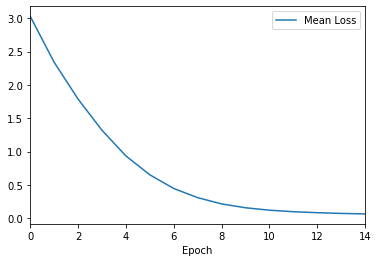

In [27]:
pd.DataFrame(mean_losses, columns=["Epoch", "Mean Loss"]).set_index("Epoch").plot()
plt.show()

As can be seen the mean loss has converged, but it is very high.

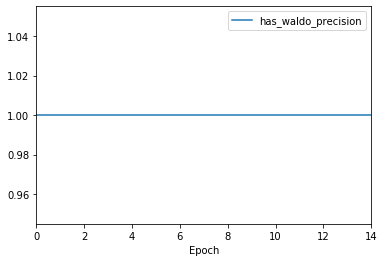

In [30]:
pd.DataFrame(has_waldo_precisions, columns=["Epoch", "has_waldo_precision"]).set_index("Epoch").plot()
plt.show()

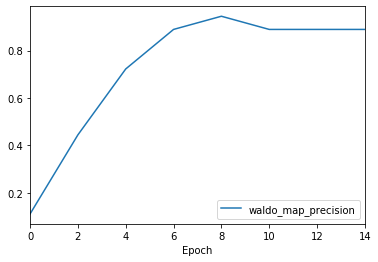

In [28]:
pd.DataFrame(waldo_map_precisions, columns=["Epoch", "waldo_map_precision"]).set_index("Epoch").plot()
plt.show()

Evidently, it performs fairly well on the task of predicting if waldo is on the map. In addition, it is able to guess with fairly good precision, the type of waldo map that it is extracting features for.